In [1]:
import geopandas as gpd
import osmnx as ox
import xgboost as xgb
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,RandomForestClassifier
import time 
import pandas as pd
import matplotlib.pyplot as plt
from  sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix,f1_score,ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score,accuracy_score

C:\Users\Diametrix\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Diametrix\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Diametrix\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\Diametrix\AppData\Roaming\Python\Python39\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\Diametrix\AppData\Local\Temp\ipykernel_948\3475871976.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force t

In [2]:
#load saved data
all_building=pickle.load(open(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\04_données clients (source)\osm filtre\\all_buildings.pkl","rb"))
iris_building_id=pickle.load(open(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\04_données clients (source)\osm filtre\\iris_building_id.pkl","rb"))
building_no_na=pickle.load(open(r"Y:\RECHERCHE ET DEV\10_Modèle d'attractivite des rues\04_données clients (source)\osm filtre\\building_no_na_type.pkl",'rb'))

In [3]:
building_no_na['building']=np.where(building_no_na['building'].isin(['apartments',"house","residential"]),1,0)

In [4]:
train,test =train_test_split(building_no_na,random_state=123)

# constant (mode)

In [7]:
iris_building_id_=iris_building_id.reset_index("index_right")

In [9]:
iris_building_id_=iris_building_id_.loc[train.index]
iris_building_id_['building_index']=list(iris_building_id_.index)
a=iris_building_id_.groupby("index_right")['building_index'].apply(list)

In [19]:
def g(x):
    mode=building_no_na.loc[x["building_index"]]['building'].mode().values[0]
    if mode <=0:
        return 1
    else:
        return mode
a=a.reset_index()
a['mode']=a.apply(lambda x:g(x),axis=1)

In [22]:
iris_test_index=pd.DataFrame([],index=iris_building_id.index.drop_duplicates()).reset_index("index_right").loc[test.index]['index_right'].values

In [23]:
y_pred=[]
for ind in iris_test_index:
    if ind in a.index:
        y_pred.append(a.loc[ind,"mode"])
        
    else:
        y_pred.append(building_no_na['building'].mean().round())

<Figure size 1440x1440 with 0 Axes>

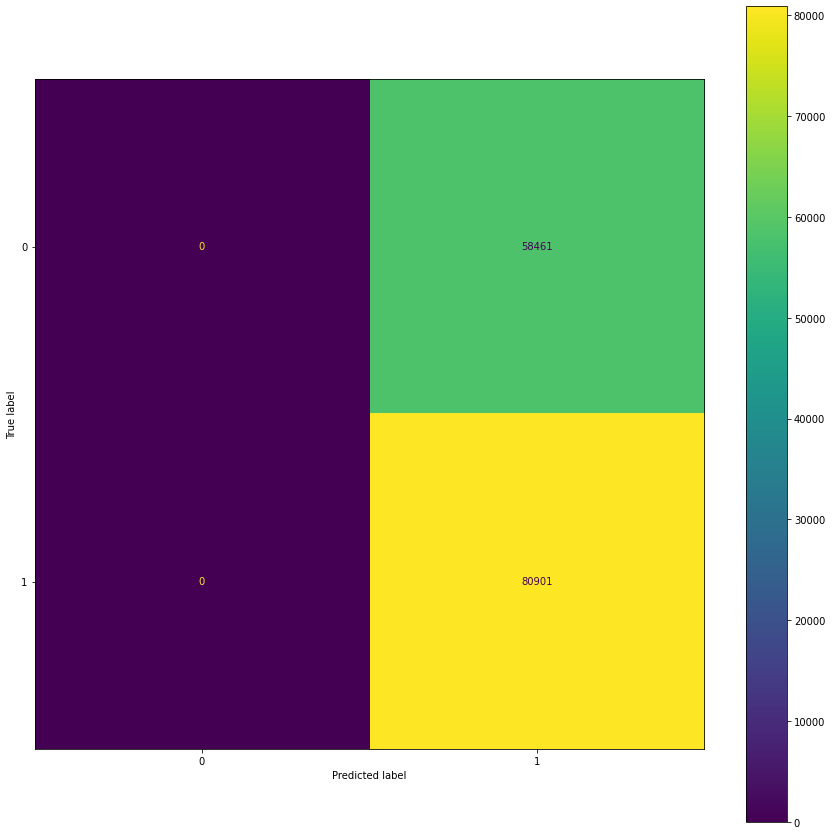

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,20))
p=ConfusionMatrixDisplay(confusion_matrix(test['building'].values,y_pred))
p.plot()
fig = p.ax_.get_figure() 
fig.set_figwidth(15)
fig.set_figheight(15)  
plt.show()

# KNN -mode

In [5]:
iris_building_id=iris_building_id.reset_index('index_right')

In [6]:

iris_building_group=iris_building_id.copy()
iris_building_group['building_index']=list(iris_building_id.index)
iris_building_group=iris_building_group.groupby("index_right")['building_index'].apply(list)

In [27]:
all_building['building']=np.where(all_building['building'].isin(["apartments","terrace","semidetached_house","residential","house","hotel","farm","dormitory","detached"]),1,0)

In [42]:
sample=building_no_na.sample(n=10000)

In [43]:
import warnings

def knn(x,k=10):
    ind=(x['element_type'],x['osmid'])
    iris_=iris_building_id.loc[ind].values[0][0]
    warnings.filterwarnings("ignore")
    building_same_iris=all_building.loc[iris_building_group.loc[iris_]]
    distances=building_same_iris.distance(x['geometry']).sort_values()
    distances=distances.drop(ind)
    type_building=building_same_iris.loc[distances.index]['building']
    type_building=type_building[type_building!="yes"]
   
    
    if len(type_building)==0:return 0
    else:return type_building.iloc[:k].mode().values[0]
        
import time
start=time.time()
result=sample.reset_index().apply(lambda x:knn(x),axis=1)
print(time.time()-start)

4331.450138092041


<Figure size 1440x1440 with 0 Axes>

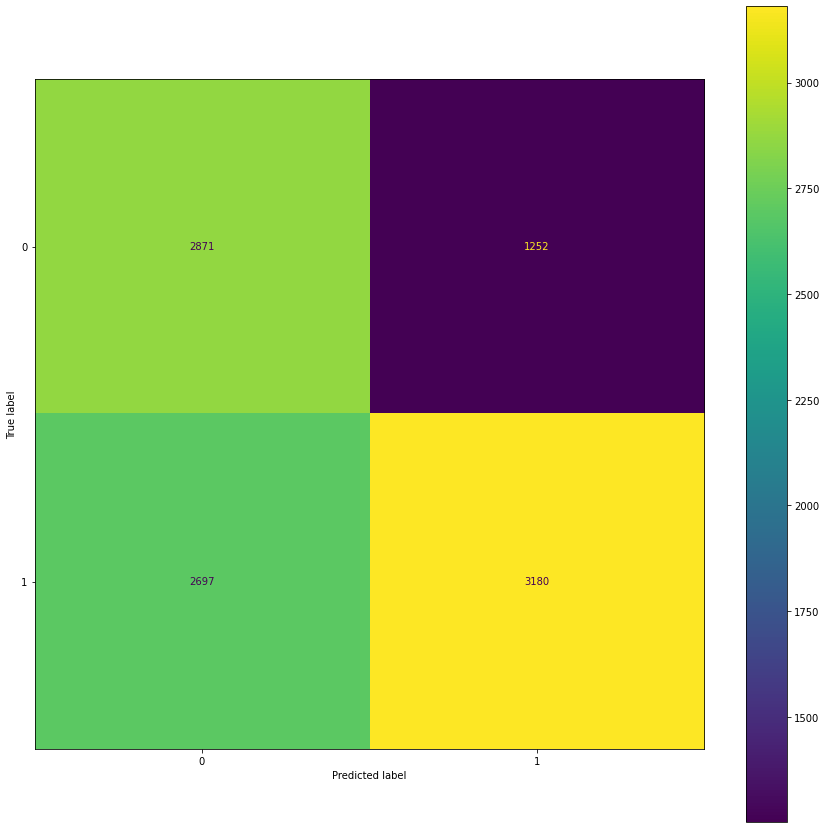

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,20))
p=ConfusionMatrixDisplay(confusion_matrix(sample['building'],result))
p.plot()
fig = p.ax_.get_figure() 
fig.set_figwidth(15)
fig.set_figheight(15)  
plt.show()

In [46]:
building_no_na

geometry  \
element_type osmid                                                           
way          78149779    POLYGON ((547418.360 5759209.807, 547410.067 5...   
             78149812    POLYGON ((547600.858 5759996.703, 547585.073 5...   
             78149829    POLYGON ((550511.094 5753205.122, 550507.432 5...   
             78149831    POLYGON ((546440.920 5758540.666, 546404.062 5...   
             78149871    POLYGON ((547365.840 5758995.472, 547353.105 5...   
...                                                                    ...   
             1060293441  POLYGON ((267490.039 6275617.467, 267481.088 6...   
             1064444549  POLYGON ((265683.524 6276015.664, 265668.295 6...   
             1092185388  POLYGON ((265291.189 6276508.935, 265315.056 6...   
relation     5160713     POLYGON ((265689.168 6275149.938, 265687.620 6...   
             5160715     POLYGON ((267720.904 6275289.149, 267735.776 6...   

                         building shop building:levels           amenity  \
element_type osmid                                                         
way          78149779           0  NaN             2.0               NaN   
             78149812           0  NaN             4.0               NaN   
             78149829           0  NaN             2.0  place_of_worship   
             78149831           0  NaN             1.0               NaN   
             78149871           0  NaN             1.0               NaN   
...                           ...  ...             ...               ...   
             1060293441         1  NaN             6.0               NaN   
             1064444549         0  NaN             3.0               NaN   
             1092185388         1  NaN             2.0               NaN   
relation     5160713            0  NaN             4.0               NaN   
             5160715            0  NaN             2.0               NaN   

                                                              name  \
element_type osmid                                                   
way          78149779                                          NaN   
             78149812                                          NaN   
             78149829             Église de l'Immaculée Conception   
             78149831                                          NaN   
             78149871                                          NaN   
...                                                            ...   
             1060293441                                        NaN   
             1064444549                                        NaN   
             1092185388                                        NaN   
relation     5160713                                           NaN   
             5160715     Centre de Formation et d'Aprentissage IMA   

                                  addr:street        addr:city  \
element_type osmid                                               
way          78149779                     NaN              NaN   
             78149812                     NaN              NaN   
             78149829                     NaN              NaN   
             78149831                     NaN              NaN   
             78149871                     NaN              NaN   
...                                       ...              ...   
             1060293441                   NaN              NaN   
             1064444549                   NaN              NaN   
             1092185388                   NaN              NaN   
relation     5160713                      NaN              NaN   
             5160715     Avenue Pierre Semard  Villiers-le-Bel   

                        addr:housenumber addr:postcode  
element_type osmid                                      
way          78149779                 19           NaN  
             78149812                NaN           NaN  
             78149829                NaN           NaN  
       